In [115]:
import pandas as pd

In [117]:
plot_dir = f"/home/ec2-user/picassoxbridgedata_coupled/s3_multi_omics/multiomics_analyses/mofa_plots/"

In [59]:
# !pip install --upgrade importlib-metadata
# !pip install --upgrade umap-learn

In [116]:
import mofapy2

print(mofapy2.__version__)

0.7.2


In [61]:
wd = "/home/ec2-user/picassoxbridgedata_coupled/s3_multi_omics/merged_transcriptomics_cellpainting/"
transcriptomics_chemistry_cell_painting_variance_filters = f"{wd}features/lyon_transcriptomics_chemistry_cellpainting_and_meta_variance_filter.csv"

In [62]:
df = pd.read_csv(transcriptomics_chemistry_cell_painting_variance_filters, index_col=0)

In [63]:
import pickle

gene_mapping = pickle.load(
    open(
        "/home/ec2-user/picassoxbridgedata_coupled/transcriptomics_analysis/gene_mapping_botrytis.pkl",
        "rb",
    )
)

In [64]:
chem_columns = df.columns[df.columns.str.startswith("CHEM")].to_list()
gene_columns = df.columns[df.columns.str.startswith("GE")].to_list()
cp_columns = df.columns[df.columns.str.startswith("CP")].to_list()
meta_columns = df.columns[df.columns.str.startswith("META")].to_list()


In [65]:
import re

uniprot_hits = ["GE_" + gene_mapping[gene.replace("GE_", "")] for gene in gene_columns]
uniprot_hits = [re.sub(r"\W+", "_", gene) for gene in uniprot_hits]


In [66]:
# Create a dictionary to track occurrences
hit_count = {}
unique_hits = []

for hit in uniprot_hits:
    if hit in hit_count:
        hit_count[hit] += 1
        unique_hits.append(f"{hit}_{hit_count[hit]}")
    else:
        hit_count[hit] = 1
        unique_hits.append(hit)

# The unique_hits list now contains entries with running numbers for duplicates

In [67]:
uniprot_hits_dict = dict(zip(gene_columns, unique_hits))

In [68]:
df.rename(columns=uniprot_hits_dict, inplace=True)
gene_columns = list(uniprot_hits_dict.values())

In [69]:
#df = df[df["METADATA_mode_of_action"]!="Protein Metabolism"]

In [70]:
from sklearn.ensemble import IsolationForest

envelope = IsolationForest(
    contamination="auto", n_jobs=-1, random_state=42
)  # Adjust contamination as needed
envelope.fit(df[gene_columns + chem_columns + cp_columns])
outlier_list = envelope.predict(
    df[gene_columns + chem_columns + cp_columns]
)  # True for outliers
#df = df[outlier_list != -1]


In [71]:
# Step 2: Extract the group information
from sklearn.preprocessing import MinMaxScaler

data = df[chem_columns + gene_columns + cp_columns].astype(float)
data = pd.DataFrame(
    MinMaxScaler().fit_transform(data), columns=data.columns, index=data.index
)
data[chem_columns] = data[chem_columns].astype(bool)

data["group"] = df["METADATA_treatment"]  # Assuming this is the column name for groups
data["sample"] = (
    df.index.astype(str)
    + "_"
    + df["METADATA_plate"]
    + "_"
    + df["METADATA_wells"]
    + "_"
    + df["METADATA_treatment"]
    + "_"
    + df["METADATA_concentration"].astype(str)
)  # Assuming this is the column name for samples
data["sample"] = data["sample"].str.replace(".", "_")
data.dropna(inplace=True, axis=0)
data["group"].astype(str)
data["group"] = [re.sub(r"\W+", "_", gene) for gene in data["group"]]
data["sample"] = [re.sub(r"\W+", "_", gene) for gene in data["sample"]]
df["sample"] = data["sample"]

# Step 3: Melt the DataFrame
mofa_df = data.melt(id_vars=["sample", "group"], var_name="feature", value_name="value")


# Step 4: Add a 'view' column based on feature prefixes
def determine_view(feature):
    if feature.startswith("GE_"):
        return "RNA"
    elif feature.startswith("CP_"):
        return "Cell Painting"
    elif feature.startswith("CHEM_"):
        return "Chemistry"
    else:
        return "Unknown"


mofa_df["view"] = mofa_df["feature"].apply(determine_view)

In [72]:
mofa_df.columns = mofa_df.columns.str.replace(r"[^A-Za-z0-9_]+", "", regex=True)
# mofa_df.index = mofa_df.index.to_series().str.replace(r'[^A-Za-z0-9_]+', '', regex=True)
mofa_df = mofa_df.applymap(
    lambda x: re.sub(r"[^A-Za-z0-9_]+", "", str(x)) if isinstance(x, str) else x
)

In [73]:
mofa_df.drop(columns=["group"], inplace=True)

In [74]:
mofa_df.dropna(axis=0, inplace=True)

In [75]:
from mofapy2.run.entry_point import entry_point

## (1) initialise the entry point
ent = entry_point()

## (2) Set data options
# - scale_views: if views have very different ranges, one can to scale each view to unit variance
ent.set_data_options(scale_views=False)



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [76]:
# (3) Set data using the data frame format
ent.set_data_df(mofa_df)


No "group" column found in the data frame, we will assume a common group for all samples...


Loaded group='single_group' view='CellPainting' with N=649 samples and D=1152 features...
Loaded group='single_group' view='Chemistry' with N=649 samples and D=976 features...
Loaded group='single_group' view='RNA' with N=649 samples and D=1144 features...





In [77]:
# using default values
ent.set_model_options()

# using personalised values
ent.set_model_options(
    factors=10, spikeslab_weights=True, ard_factors=True, ard_weights=True
)

Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (CellPainting): gaussian
- View 1 (Chemistry): bernoulli
- View 2 (RNA): gaussian


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (CellPainting): gaussian
- View 1 (Chemistry): bernoulli
- View 2 (RNA): gaussian




In [78]:
# using default values
ent.set_train_options()

# using personalised values
ent.set_train_options(
    # iter = 100,
    convergence_mode="slow",
    # dropR2=None,
    gpu_mode=False,
    # save_interrupted = True,
    seed=42,
)

ent.build()

ent.run()



######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -11596720.10 

Iteration 1: time=0.55, ELBO=-243135.30, deltaELBO=11353584.796 (97.90341322%), Factors=10
Iteration 2: time=0.45, ELBO=55577.08, deltaELBO=298712.383 (2.57583507%), Factors=10
Iteration 3: time=0.45, ELBO=247767.47, deltaELBO=192190.392 (1.65728232%), Factors=10
Iteration 4: time=0.49, ELBO=335785.35, deltaELBO=88017.880 (0.75898943%), Factors=10
Iteration 5: time=0.46, ELBO=403297.17, deltaELBO=67511.819 (0.58216305%), Factors=10
Iteration 6: time=0.46, ELBO=451328.48, deltaELBO=48031.310 (0.41418013%), Factors=10
Iteration 7: time=0.68, ELBO=481536.68, deltaELBO=30208.195 (0.26048913%), Factors=10
Iteration 8: time=0.41, ELBO=498911.13, deltaELBO=17374.450 (0.14982211%), Factors=10
Iteration 9: time=0.42, ELBO=509462.80, deltaELBO=10551.676 (0.09098845%), Factors=10
Iteration 10: time=0.44, ELBO=517305.46, deltaELBO=7842.659 (0.

In [118]:
import mofax as mfx

# m = mfx.mofa_model(ent)

In [119]:
ent.save(
    outfile="mofa_model.hdf5",
    save_data=True,
    # save_model=True
)

Saving model in mofa_model.hdf5...


OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [82]:
import pandas as pd
from matplotlib import rcParams

rcParams["figure.dpi"] = 200

# m = ent
m = mfx.mofa_model("mofa_model.hdf5")

In [83]:
meta_merge = df[meta_columns]
meta_merge.index = df["sample"]

In [84]:
m.metadata = m.metadata.join(meta_merge)

In [85]:
# m.metadata["METADATA_mode_of_action"] = m.metadata["METADATA_mode_of_action"].astype("category")
# m.metadata["group"] = m.metadata["METADATA_target"]

In [86]:
import matplotlib.pyplot as plt

In [87]:
mfx.plot_factors_scatter(
    m,
    x="Factor1",
    y="Factor2",
    color="METADATA_mode_of_action",
    palette = "tab10",
    group_label="METADATA_mode_of_action"
)
plt.savefig(f"{plot_dir}mofa_scatter_moa.png", bbox_inches='tight')
plt.close()

In [88]:
mfx.plot_factors_scatter(
    m,
    x="Factor1",
    y="Factor2",
    color="METADATA_target",
    palette = "tab10",
    group_label="METADATA_target"
)
plt.savefig(f"{plot_dir}mofa_scatter_target.png", bbox_inches='tight')
plt.close()


In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

ax = mfx.plot_weights(m, factor=2, n_features=5, y_repel_coef=0.1, x_rank_offset=-150)
# ax.set_title("Feature weight analysis")
plt.savefig(f"{plot_dir}mofa_feature_weights.png", bbox_inches='tight')
plt.close()
# repel coefficient and offsets can be useful to move labels around
# and there are x_rank_offset and x_rank_offset_neg for positive and negative weights respectively

<Figure size 4000x4000 with 0 Axes>

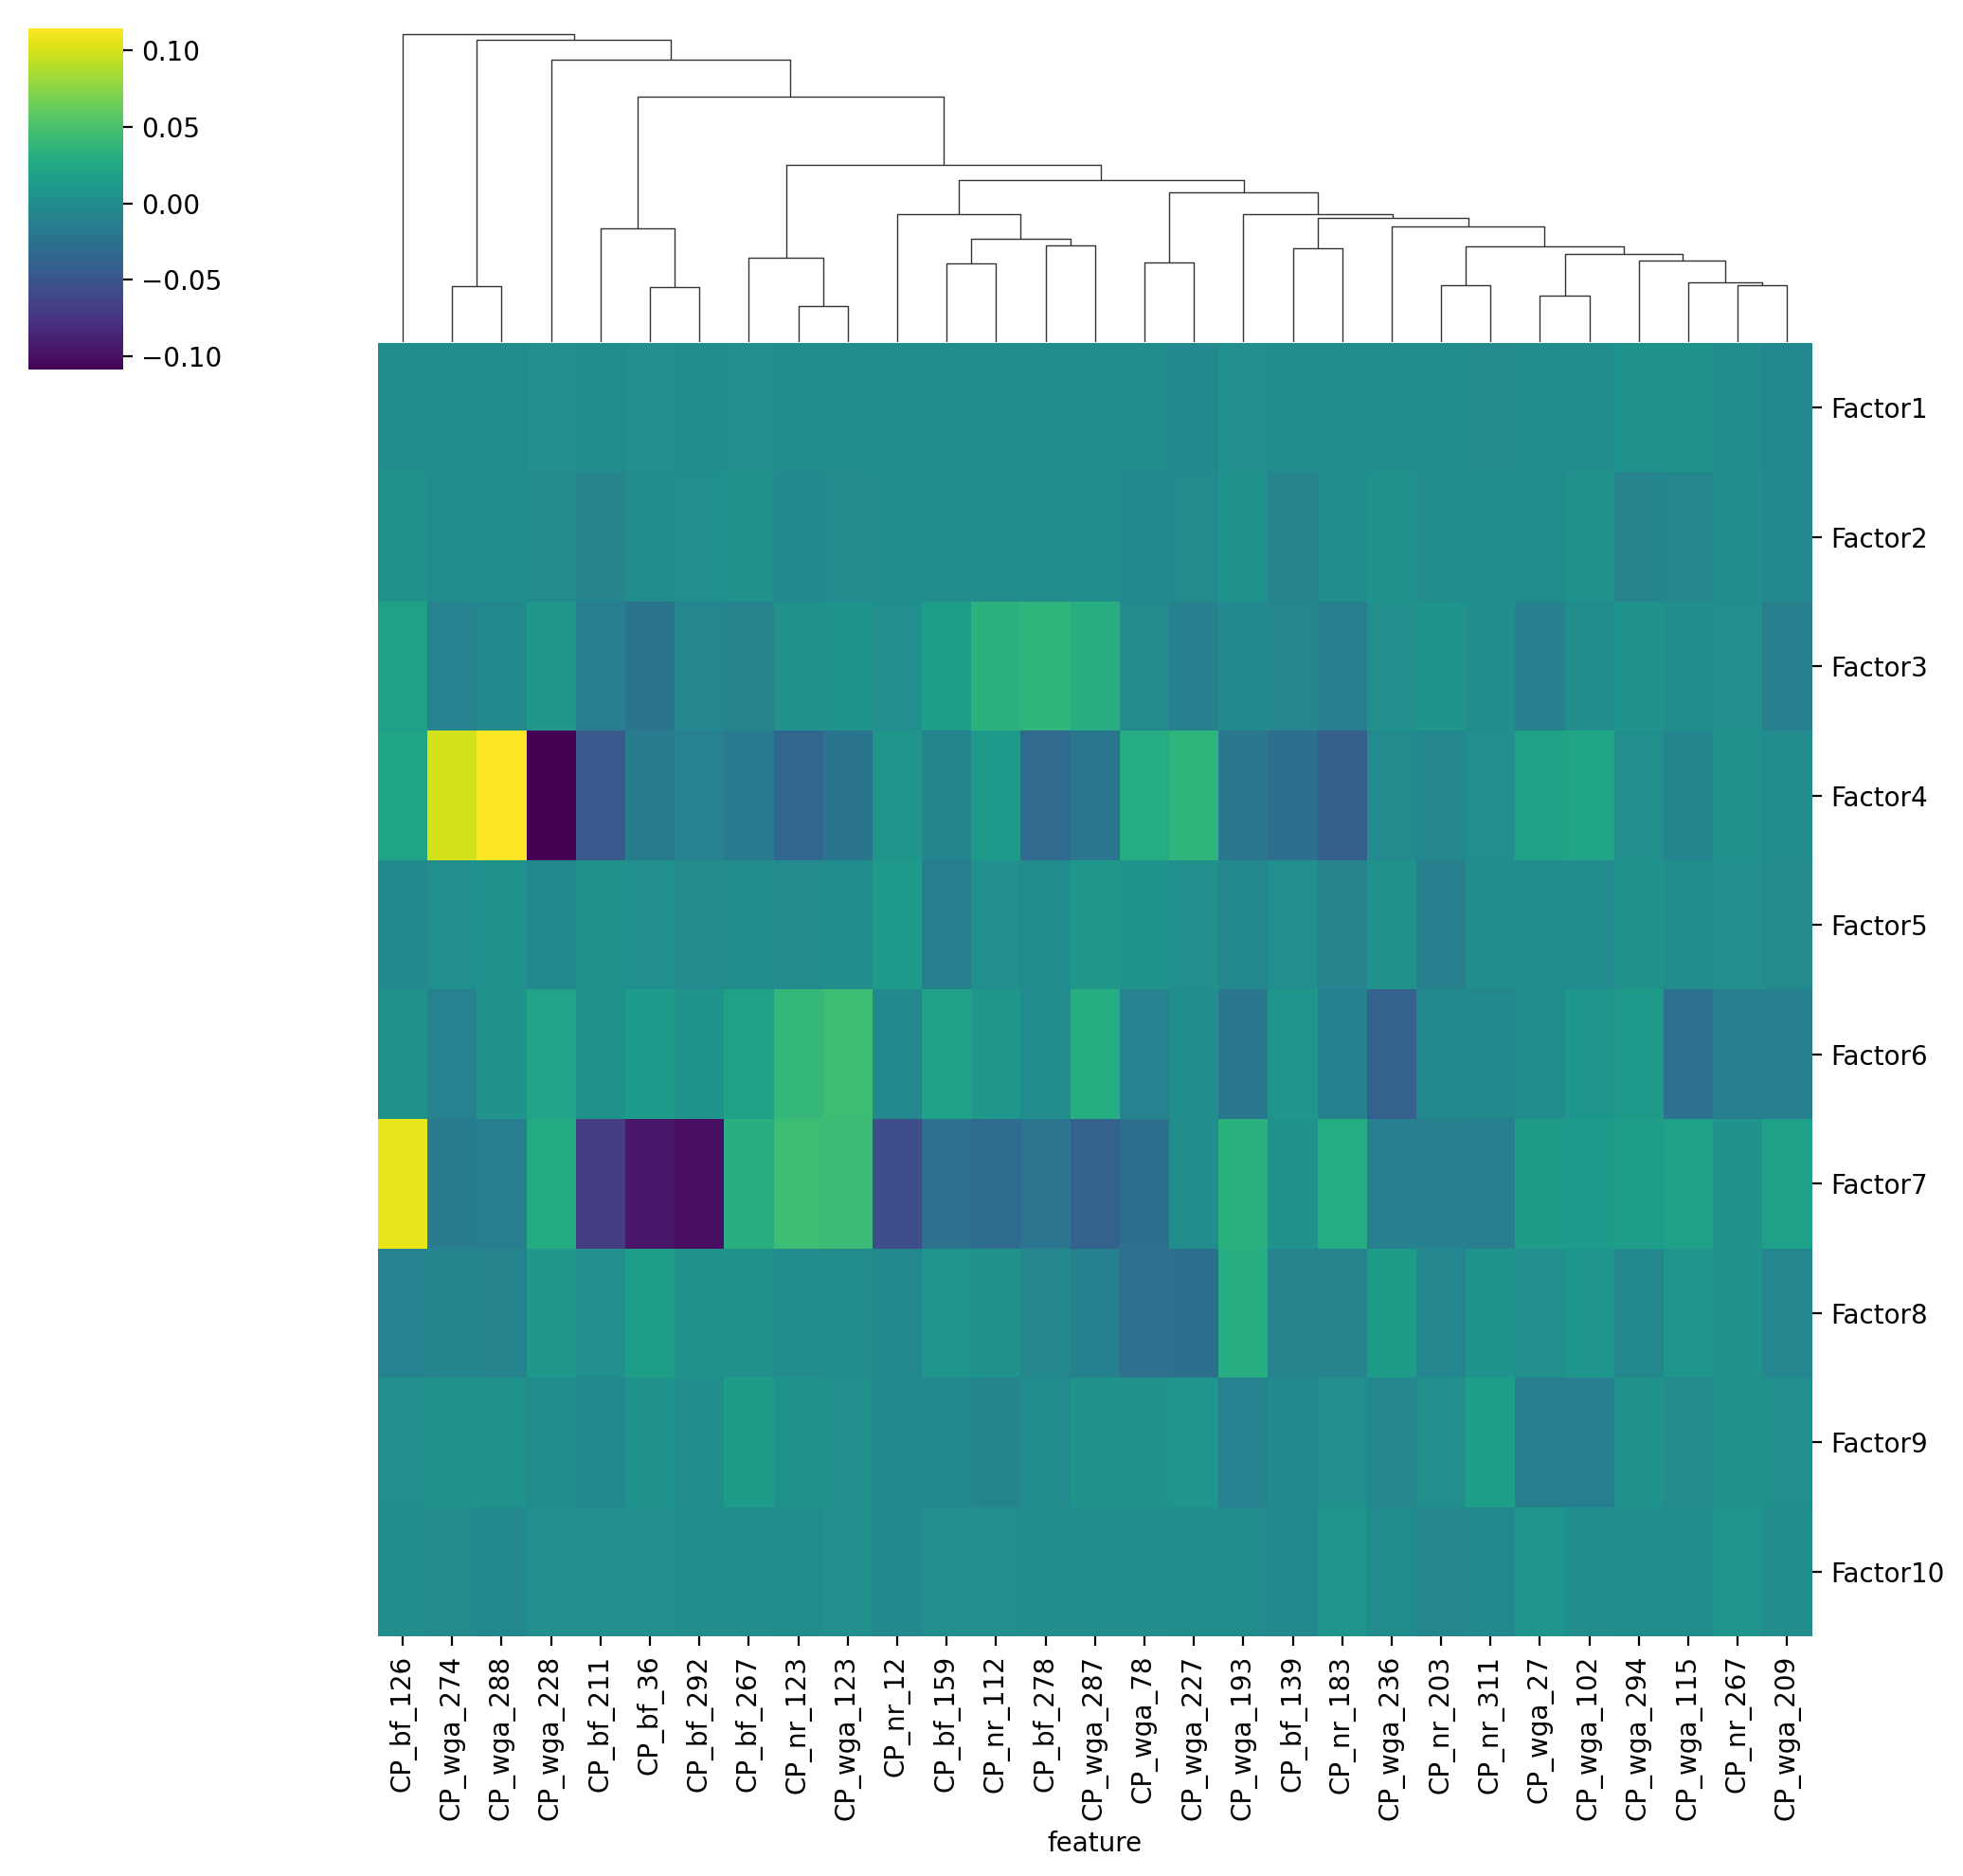

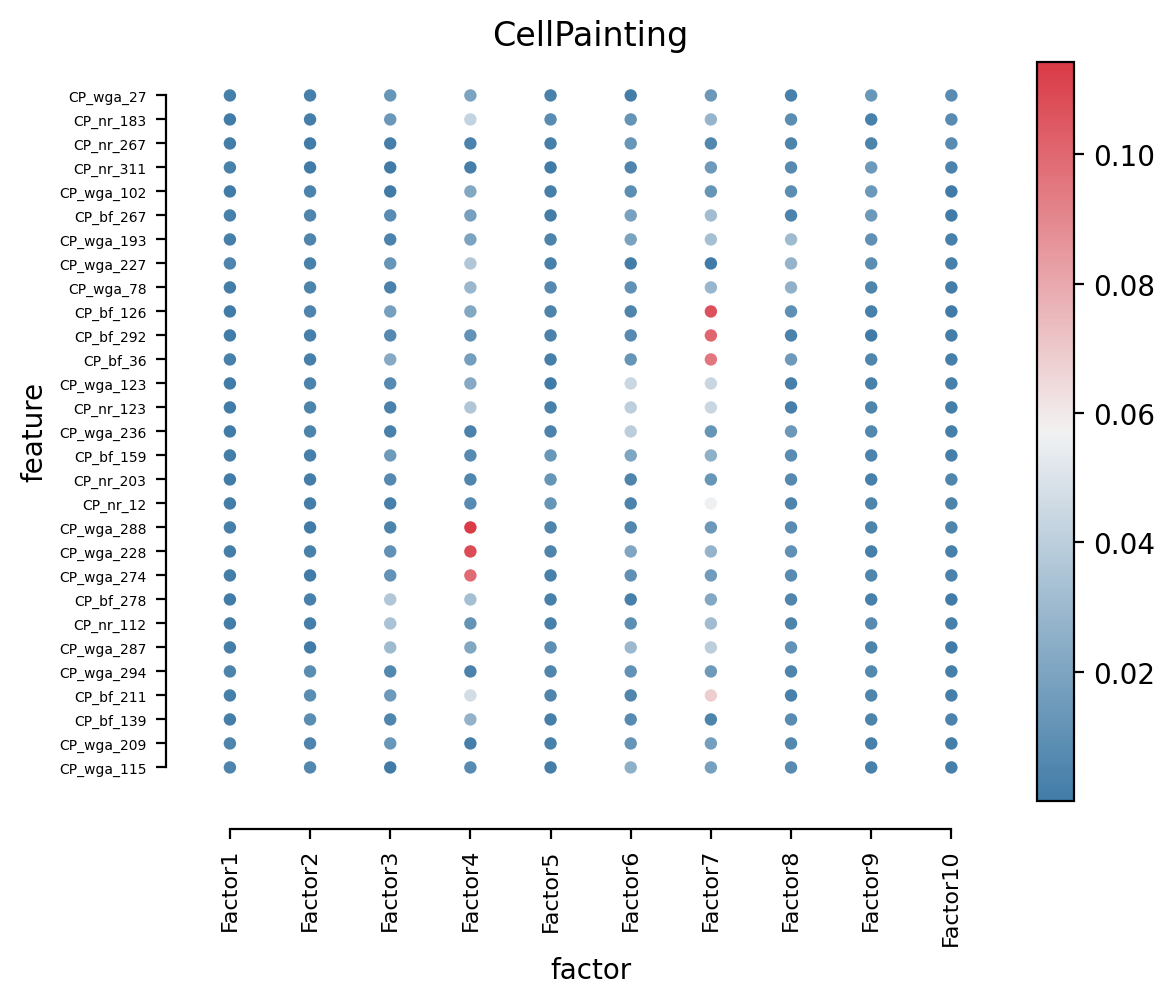

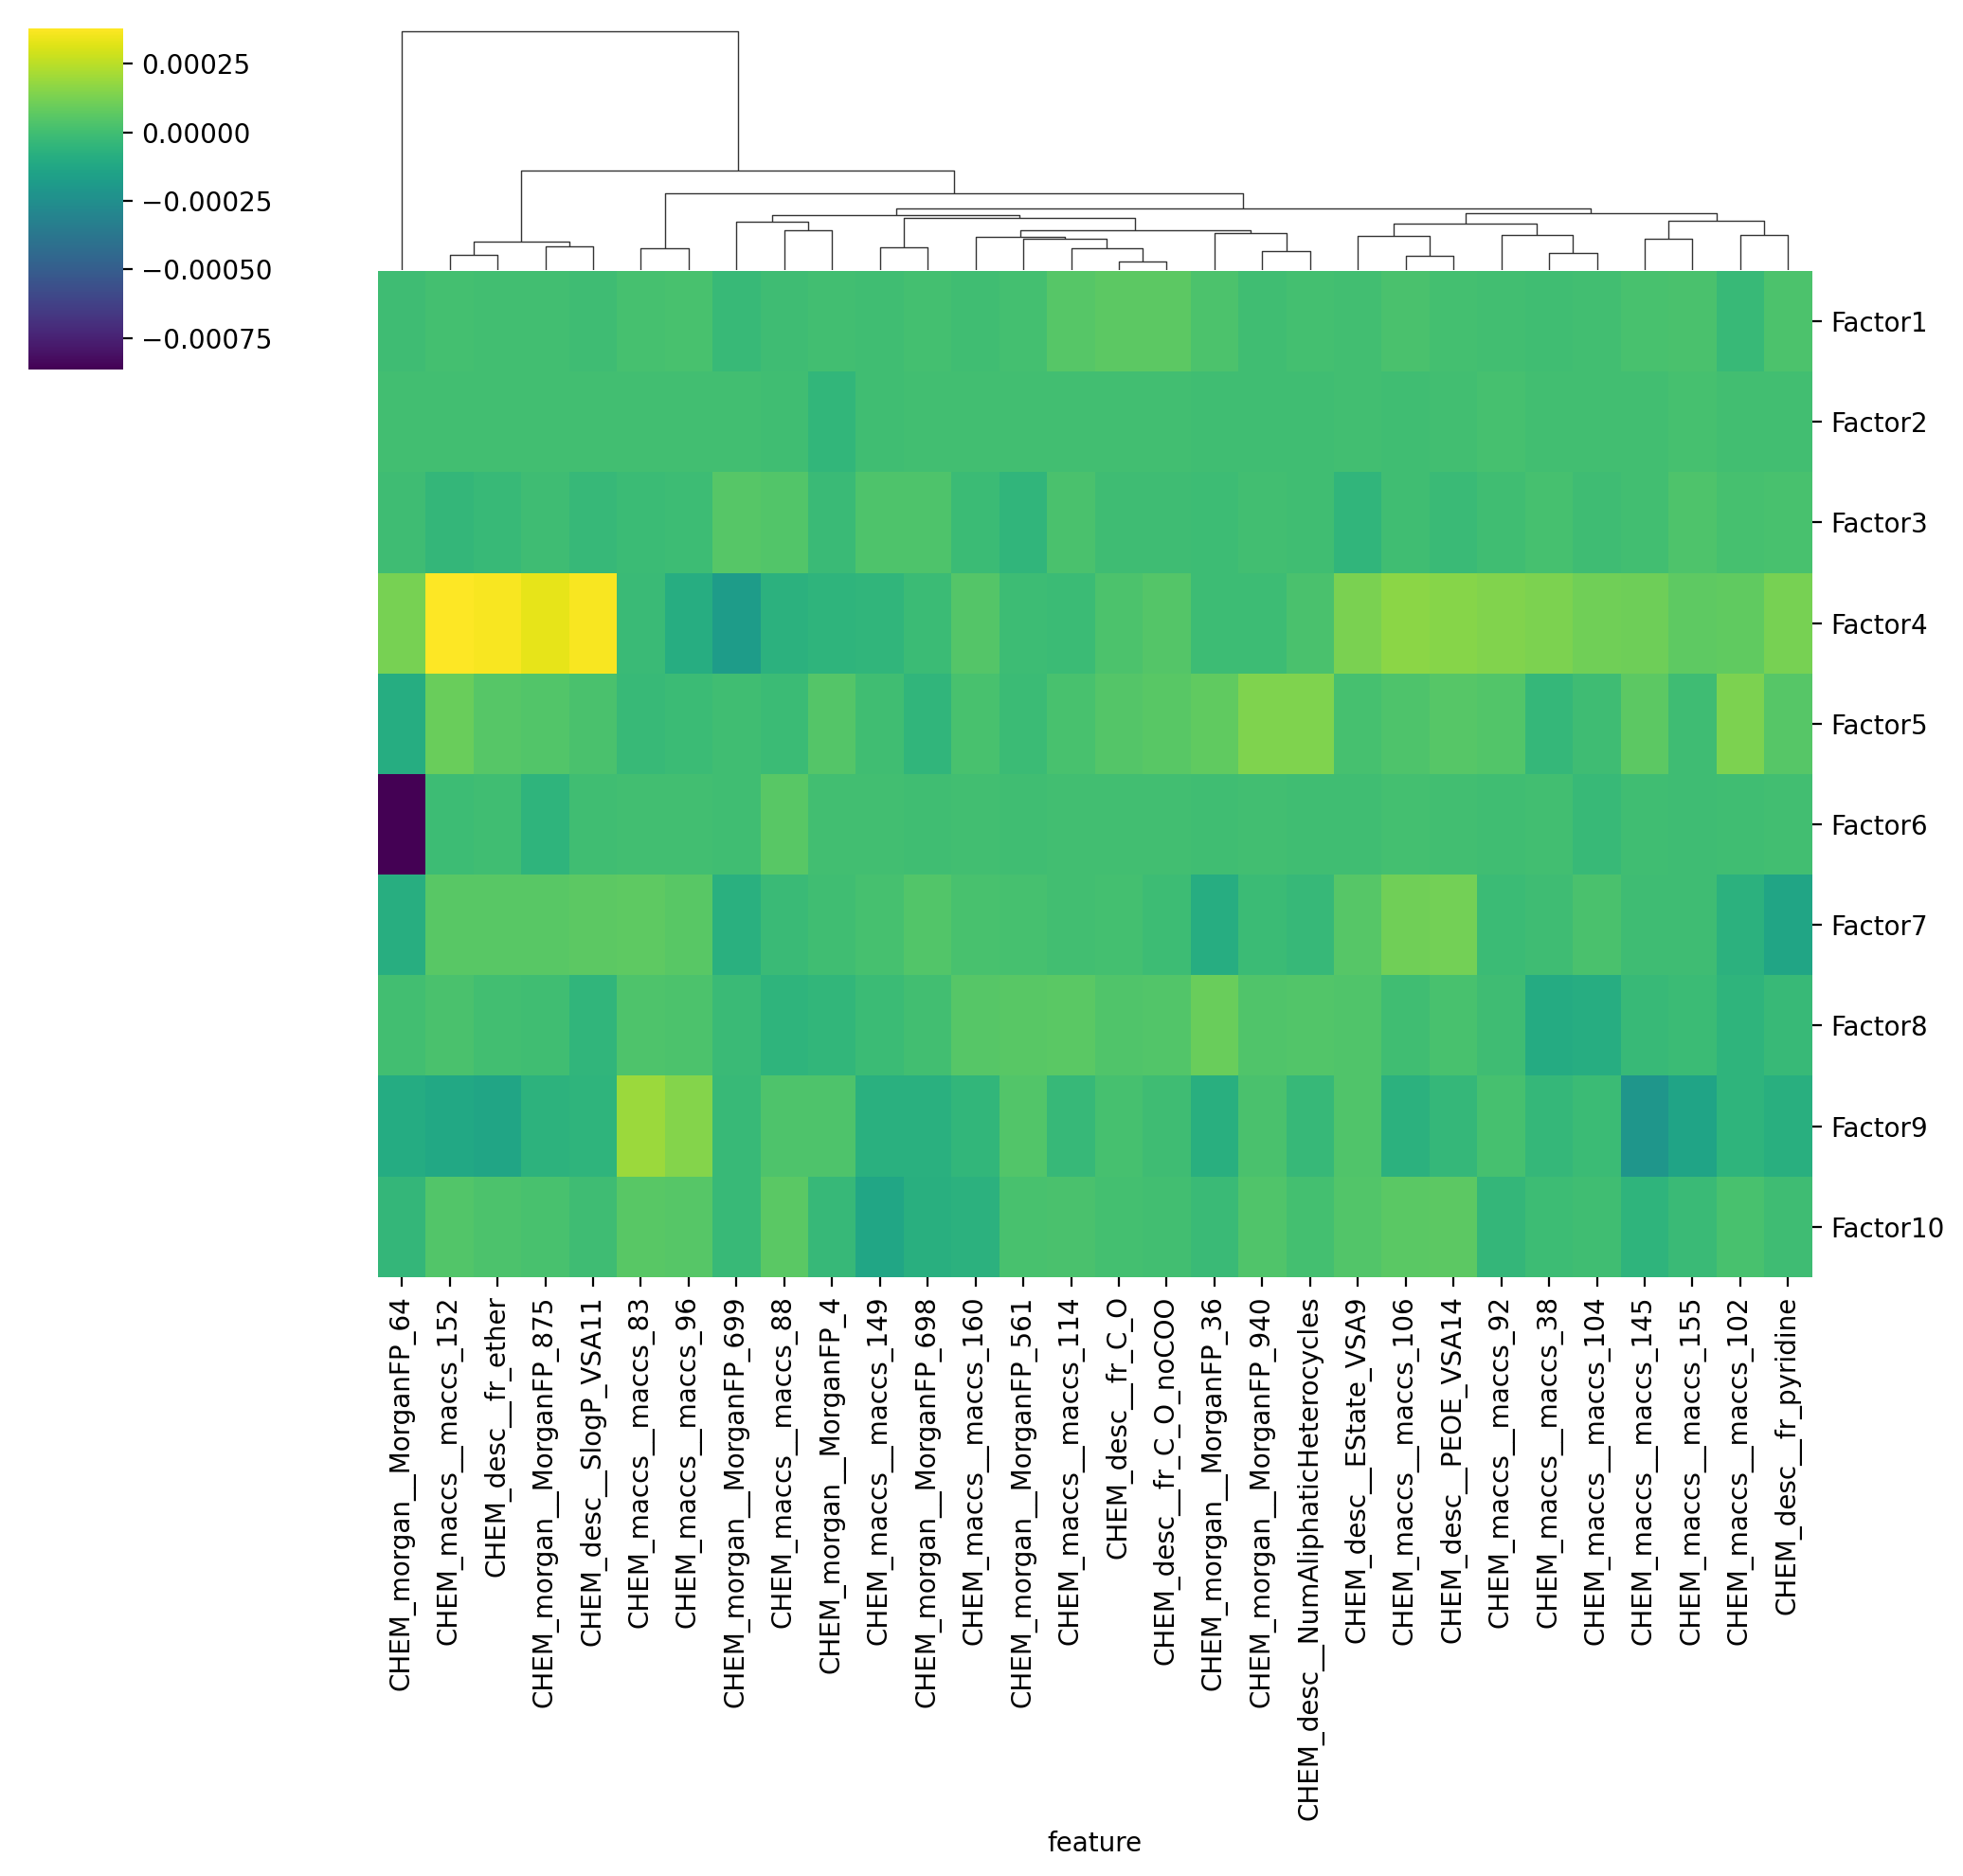

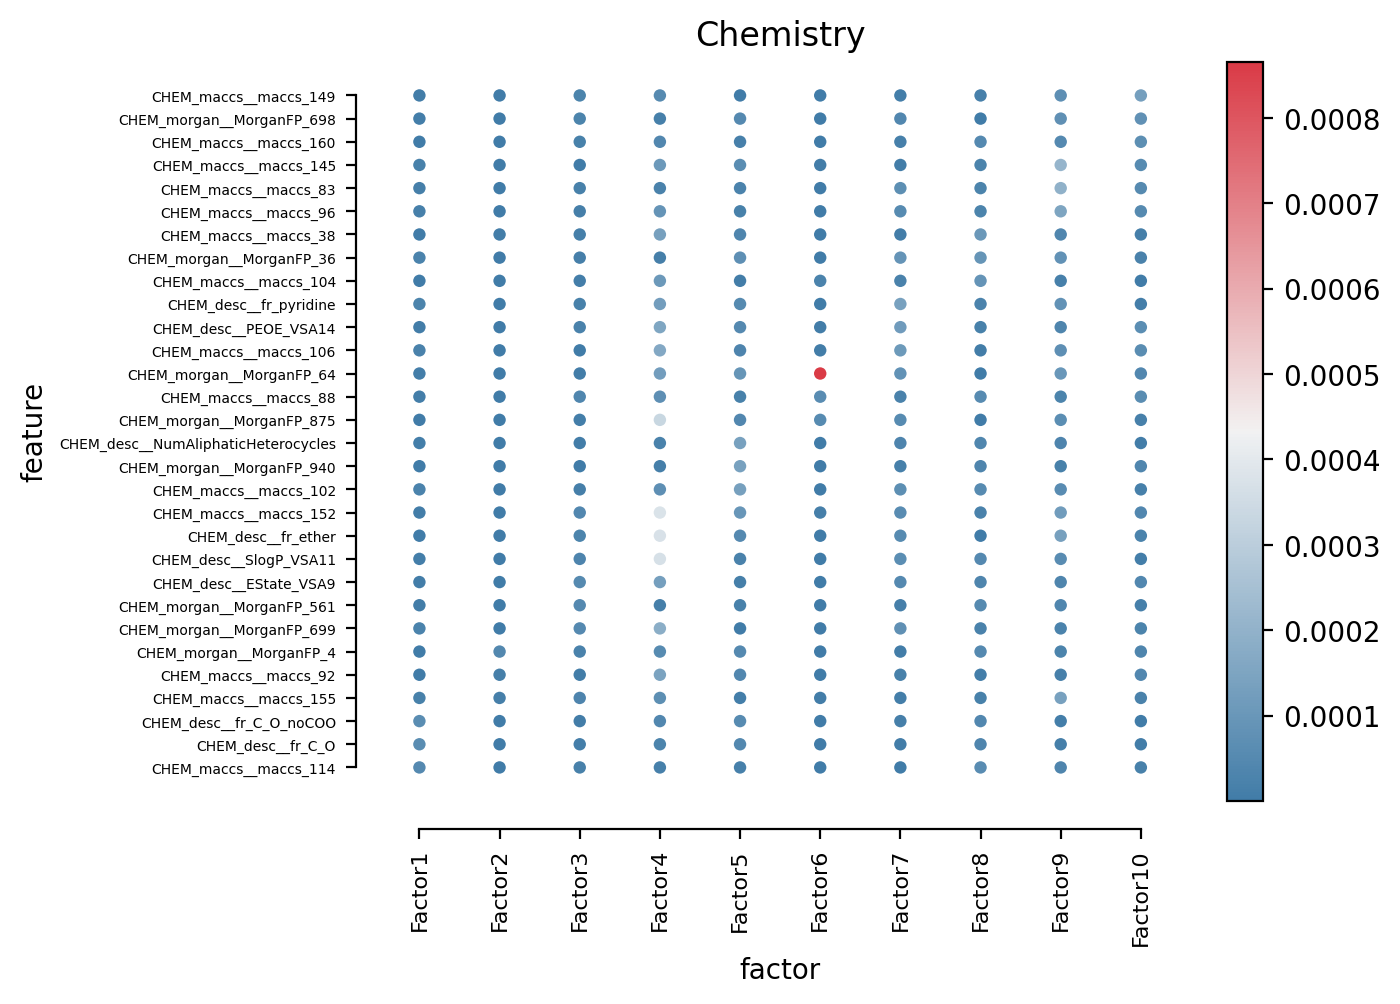

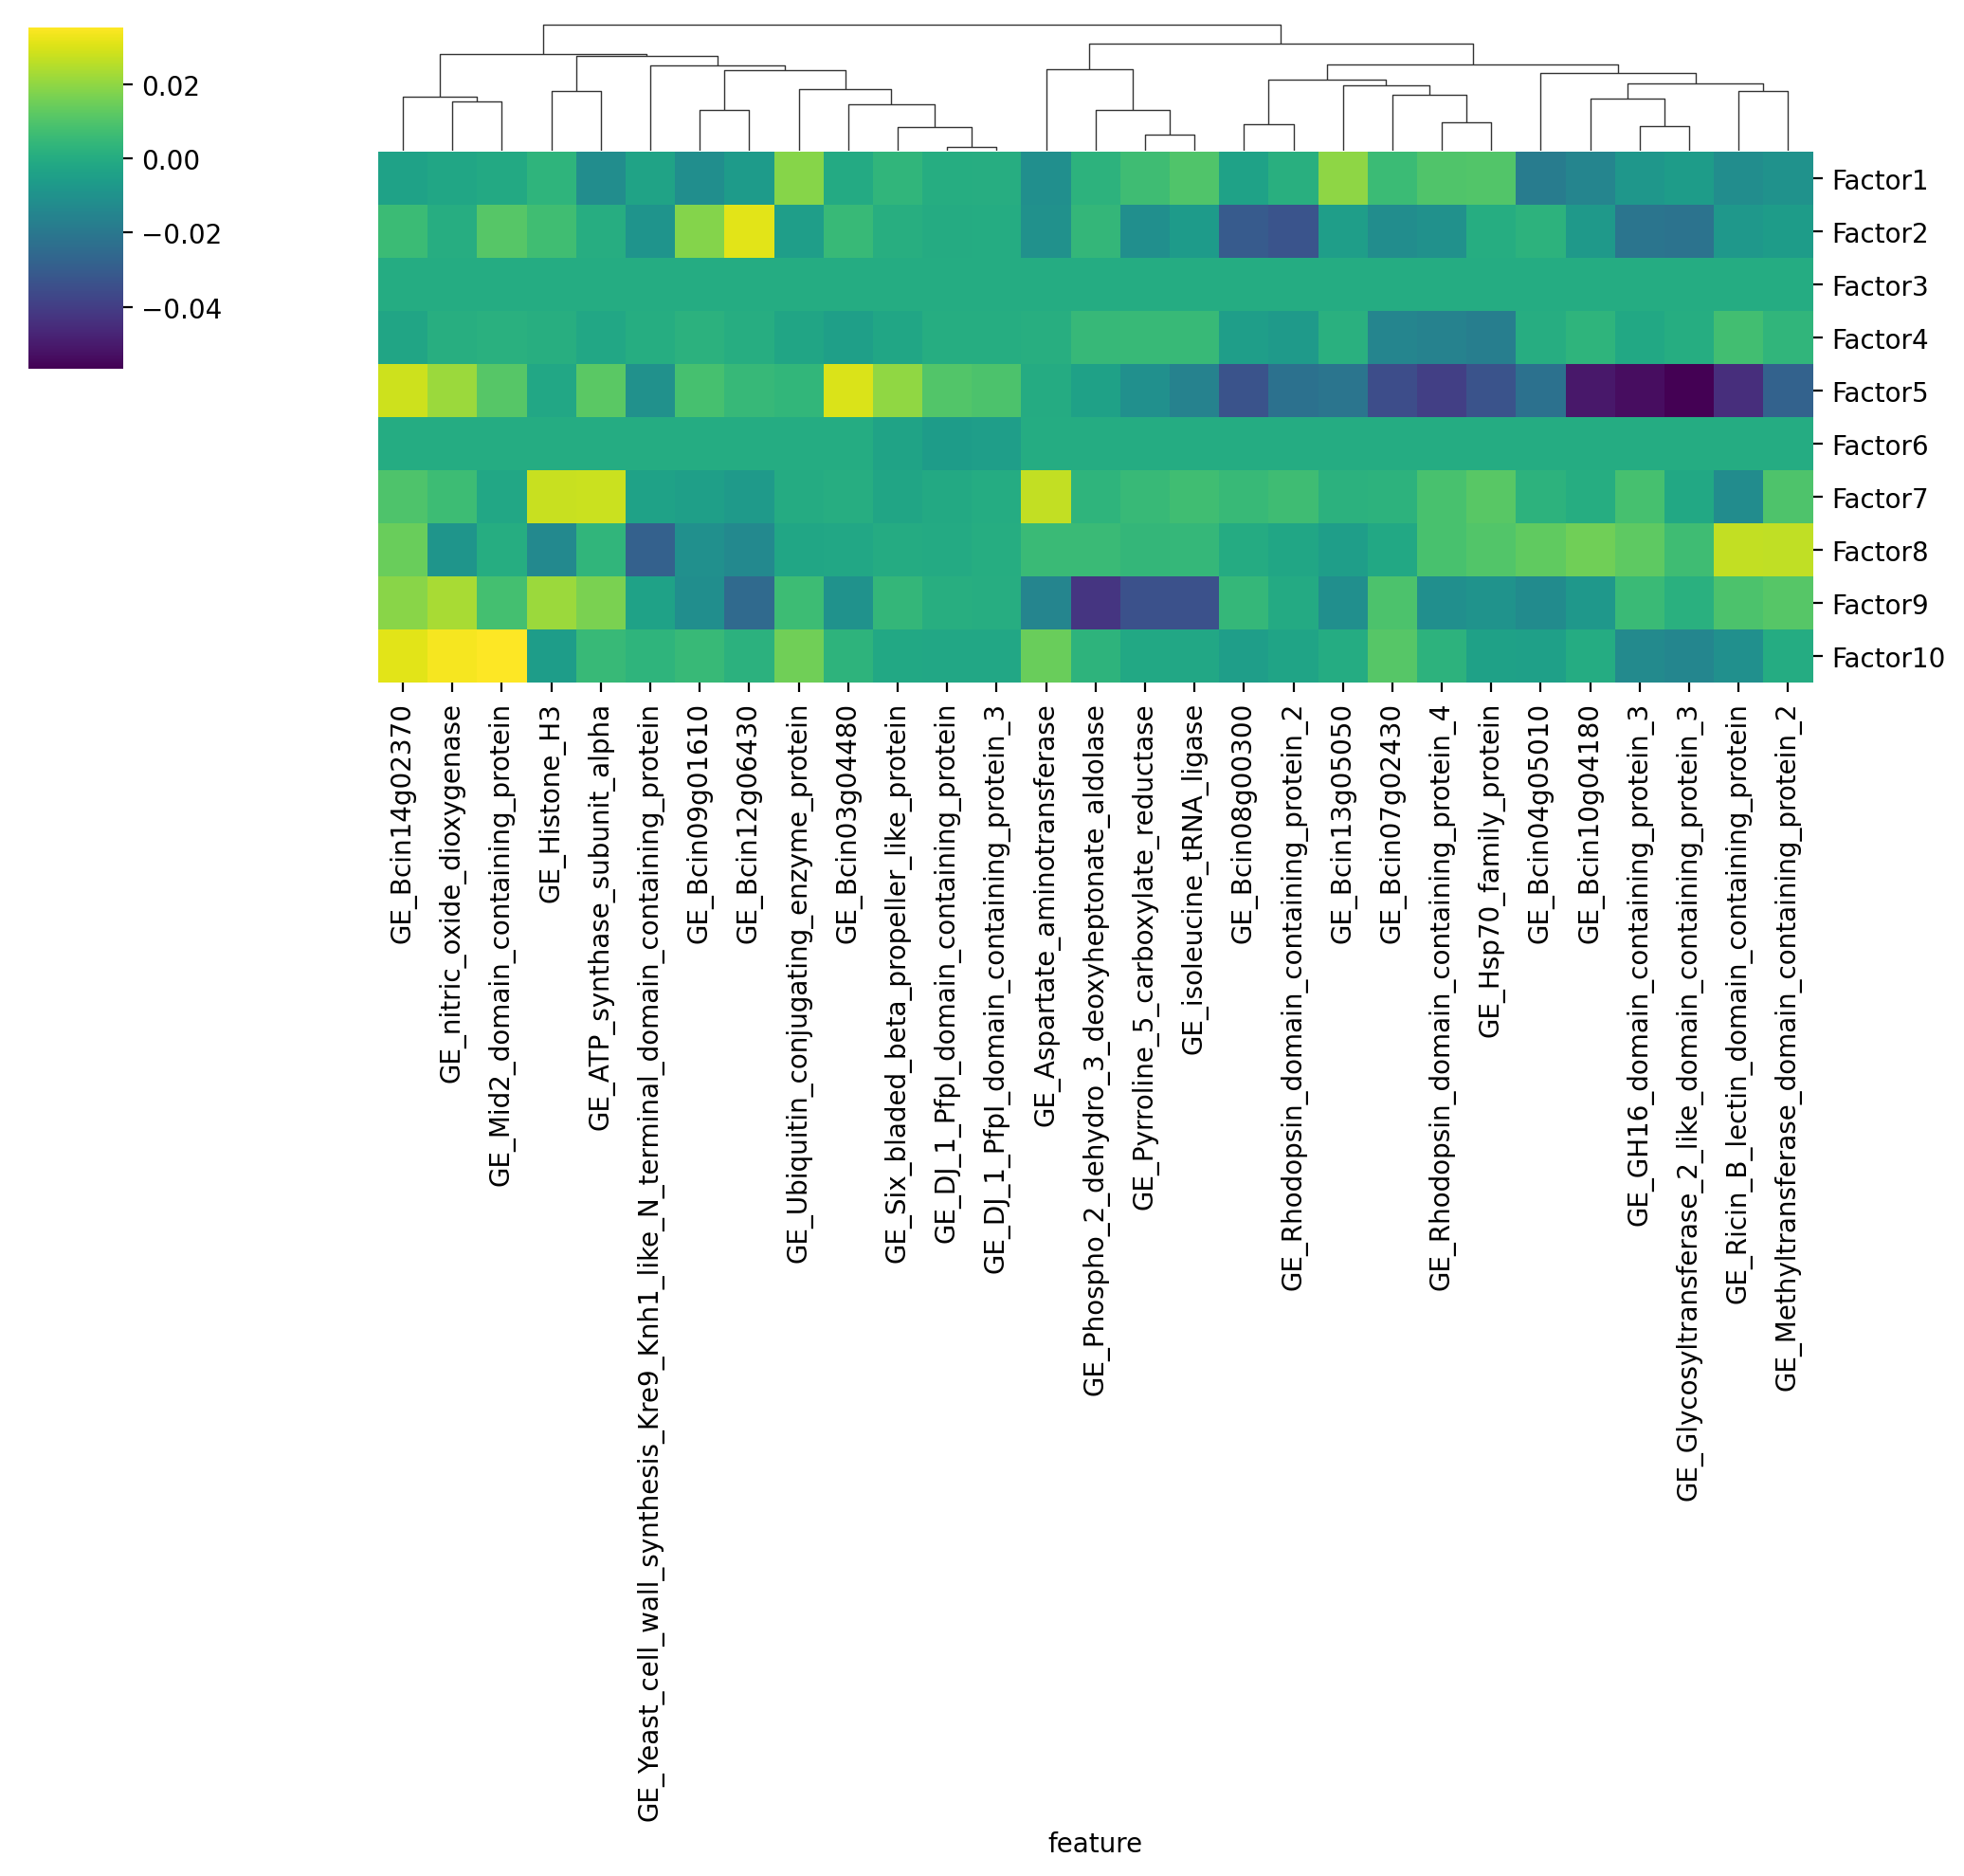

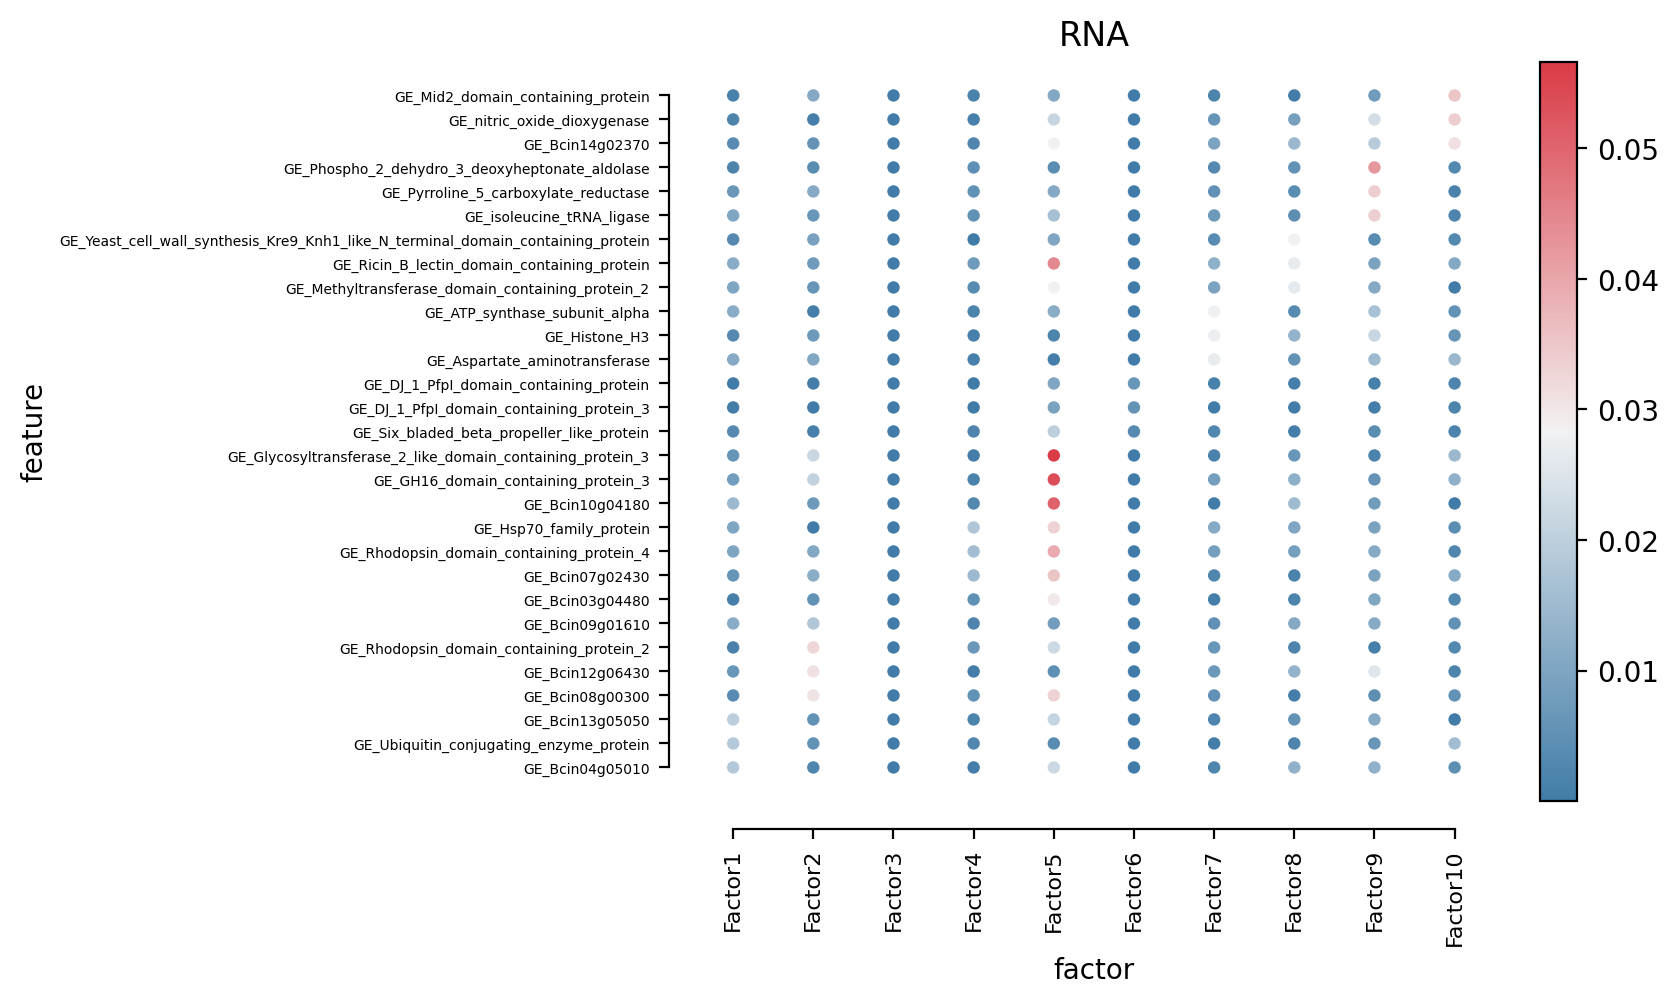

In [188]:
for view in m.views:
    mfx.plot_weights_heatmap(
        m,
        n_features=3,
        view=view,
        factors=range(10),
        #xticklabels_size=5,
        w_abs=False,
        cmap="viridis",
        cluster_factors=False,
    )
    plt.savefig(f"{plot_dir}mofa_{view}_weights_heatmap.png", bbox_inches='tight')
    #plt.close()

    mfx.plot_weights_dotplot(
        m,
        n_features=3,
        w_abs=True,
        factors=list(range(10)),
        view=view,
        # col_wrap=4,
        yticklabels_size=5,
    )
    plt.savefig(f"{plot_dir}mofa_{view}_weights_dotplot.png", bbox_inches='tight')
    #plt.close()


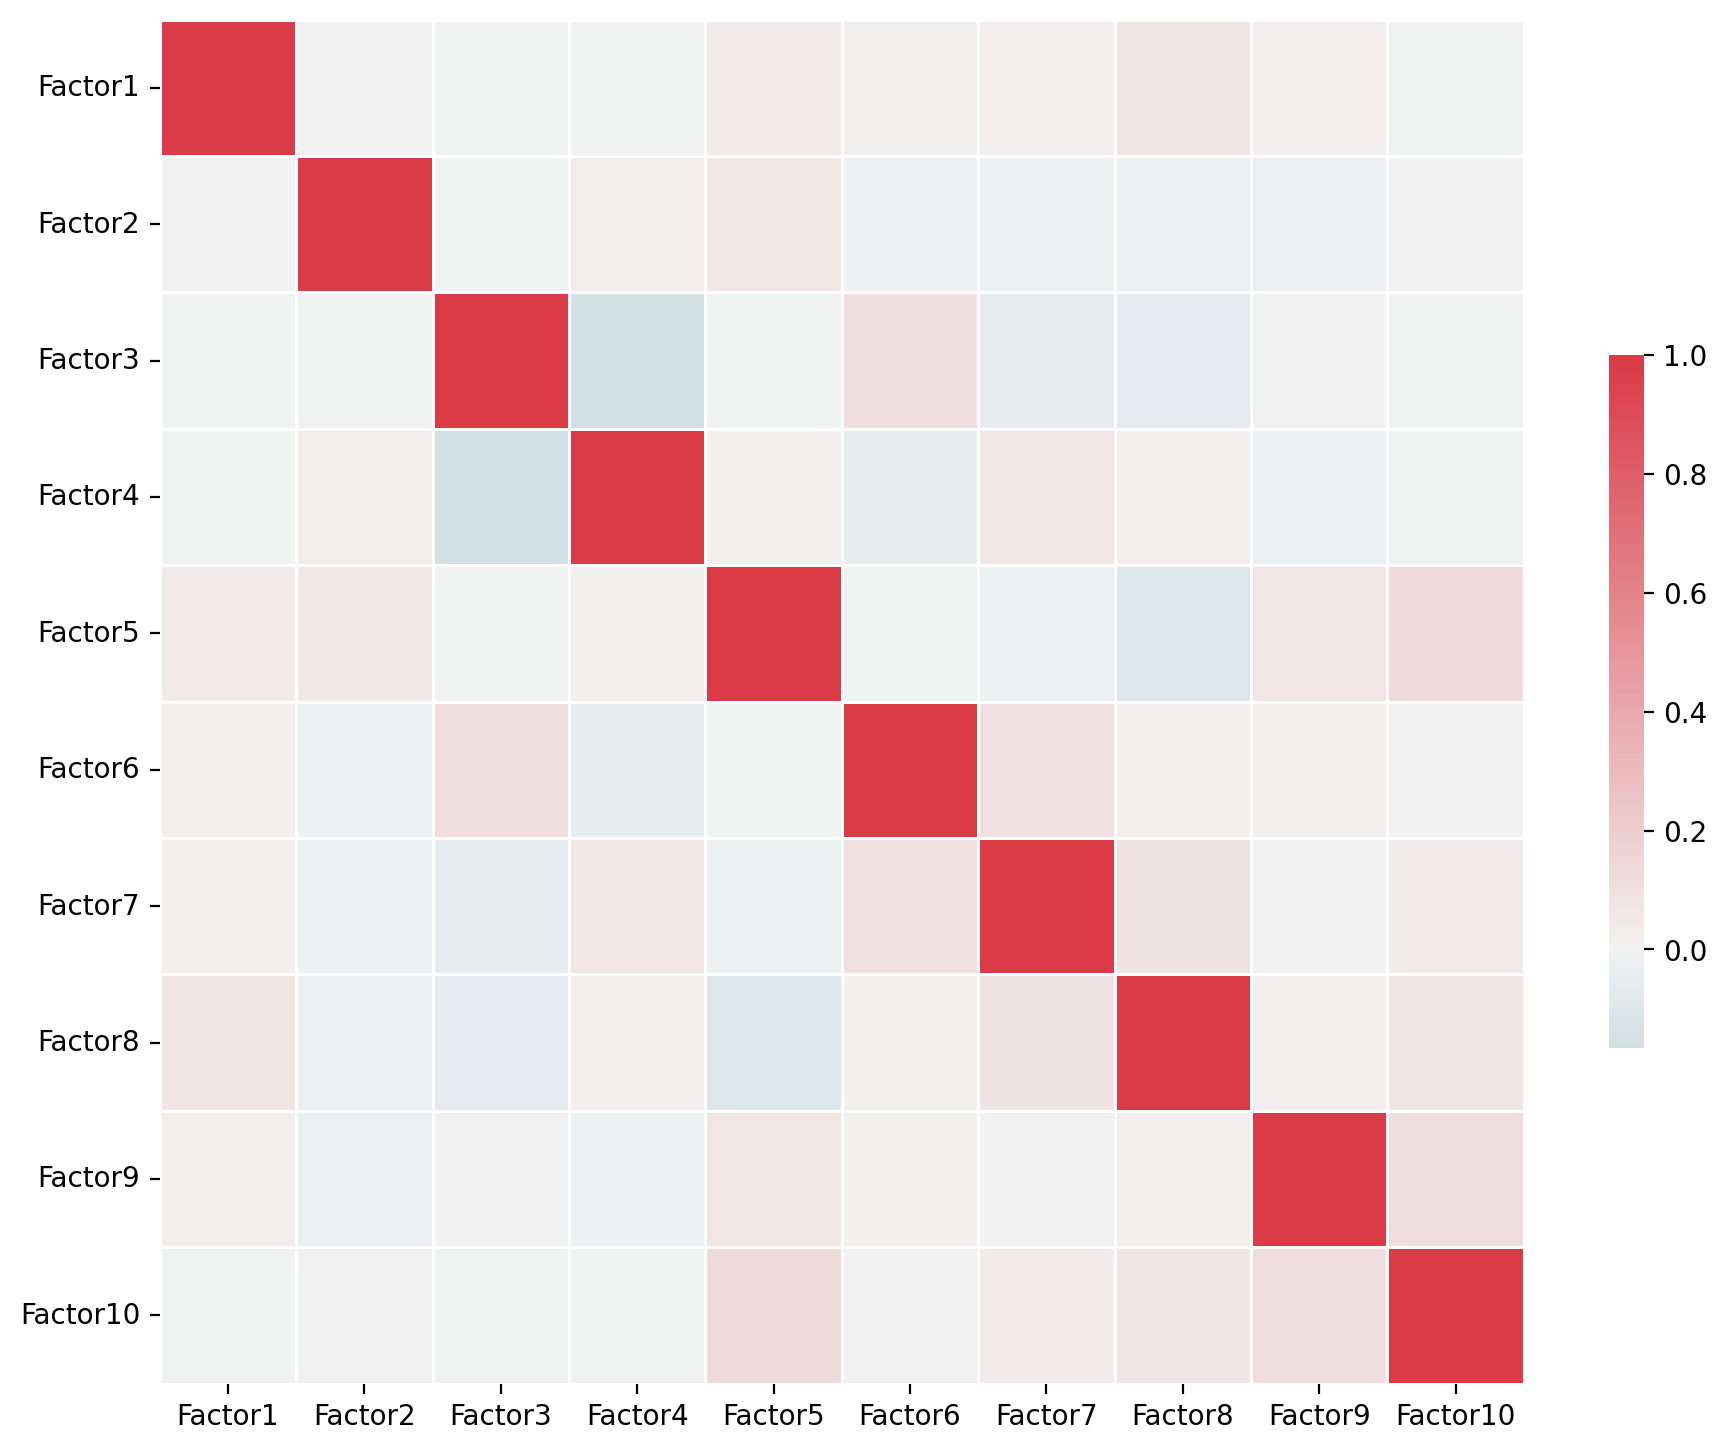

In [121]:
mfx.plot_weights_correlation(m)
plt.savefig(f"{plot_dir}mofa_factor_correlation.png", bbox_inches='tight')
# plt.close()


In [92]:
m.get_r2(factors=list(range(4))).sort_values("R2", ascending=False)

,Factor,View,Group,R2
2,Factor1,RNA,single_group,22.758886
5,Factor2,RNA,single_group,15.428752
6,Factor3,CellPainting,single_group,12.381247
9,Factor4,CellPainting,single_group,9.713436
3,Factor2,CellPainting,single_group,0.866362
0,Factor1,CellPainting,single_group,0.613411
11,Factor4,RNA,single_group,0.449096
10,Factor4,Chemistry,single_group,0.001161
1,Factor1,Chemistry,single_group,0.000646
7,Factor3,Chemistry,single_group,0.000428


In [172]:
def plot_r2(
    model: object,
    x="Group",
    y="Factor",
    factors: Union[int, List[int], str, List[str]] = None,
    group_label: str = None,
    views=None,
    groups=None,
    cmap="Blues",
    vmin=None,
    vmax=None,
    **kwargs,
):
    """
    Plot R2 values for the model

    Parameters
    ----------
    model : mofa_model
        Factor model
    x : str
        Dimension along X axis: Group (default), View, or Factor
    y : str
        Dimension along Y axis: Group, View, or Factor (default)
    factors : optional
        Index of a factor (or indices of factors) to use (all factors by default)
    views : optional
        Make a plot for certain views (None by default to plot all views)
    groups : optional
        Make a plot for certain groups (None by default to plot all groups)
    group_label : optional
        Sample (cell) metadata column to be used as group assignment
    cmap : optional
        The colourmap for the heatmap (default is 'Blues' with darker colour for higher R2)
    vmin : optional
        Display all R2 values smaller than vmin as vmin (0 by default)
    vmax : optional
        Display all R2 values larger than vmax as vmax (derived from the data by default)
    """
    if group_label is None:
        r2 = model.get_variance_explained(
            factors=factors,
            groups=groups,
            views=views,
        )
    else:
        r2 = model.calculate_variance_explained(
            factors=factors,
            groups=groups,
            views=views,
            group_label=group_label,
            per_factor=True,
        )

    vmax = r2.R2.max() if vmax is None else vmax
    vmin = 0 if vmin is None else vmin

    split_by = [dim for dim in ["Group", "View", "Factor"] if dim not in [x, y]]

    split_by = split_by[0]

    split_by_items = r2[split_by].unique()
    fig, axes = plt.subplots(ncols=len(split_by_items), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    if len(split_by_items) == 1:
        axes = [axes]
    dataframes = []
    for i, item in enumerate(split_by_items):
        r2_sub = r2[r2[split_by] == item]
        r2_df = r2_sub.sort_values("R2").pivot(index=y, columns=x, values="R2")

        if y == "Factor":
            # Sort by factor index
            r2_df.index = r2_df.index.astype("category")
            r2_df.index = r2_df.index.reorder_categories(
                sorted(r2_df.index.categories, key=lambda x: int(x.split("Factor")[1]))
            )
            r2_df = r2_df.sort_values("Factor")

        if x == "Factor":
            # Re-order columns by factor index
            r2_df.columns = r2_df.columns.astype("category")
            r2_df.columns = r2_df.columns.reorder_categories(
                sorted(
                    r2_df.columns.categories, key=lambda x: int(x.split("Factor")[1])
                )
            )
            r2_df = r2_df[r2_df.columns.sort_values()]

        g = sns.heatmap(
            r2_df.sort_index(level=0, ascending=False),
            ax=axes[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            **kwargs,
        )
        axes[i].set_title(item)
        #axes[i].tick_params(axis="both", which="both", length=0)
        if i == 0:
            g.set_yticklabels(g.yaxis.get_ticklabels(), rotation=0)
        else:
            axes[i].set_ylabel("")
        dataframes.append((item, r2_df))
        # Ensure all x-tick labels are shown
        

    plt.close()
    return dataframes

In [173]:
import matplotlib.pyplot as plt

# Call the plotting function and get the figure
dataframes = plot_r2(
    m,
    factors=list(range(10)),
    group_label="METADATA_mode_of_action",
    cmap="Blues",
)

In [177]:
vmax = max([df[1].max().max() for df in dataframes])

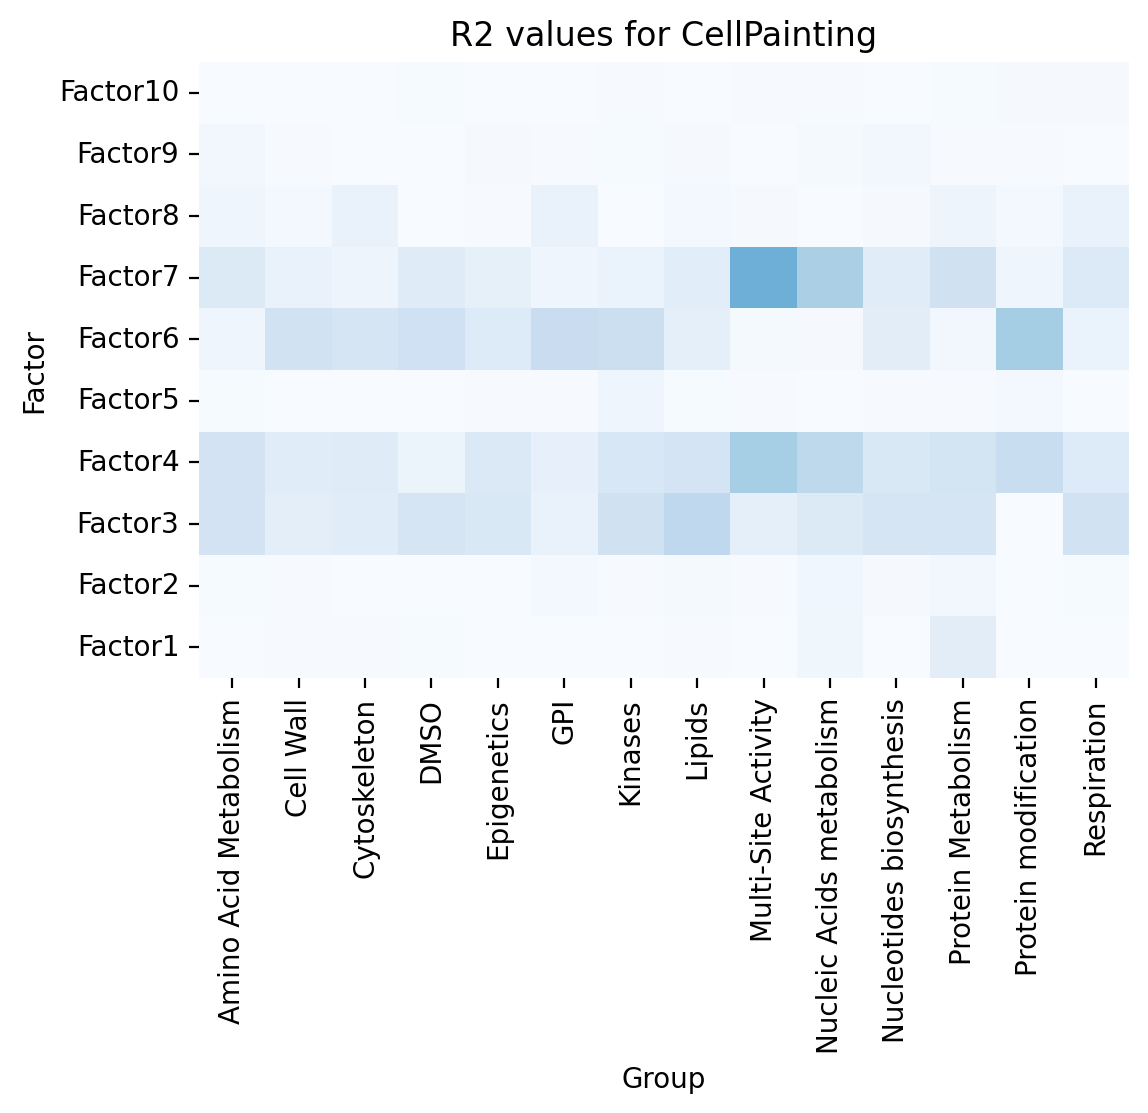

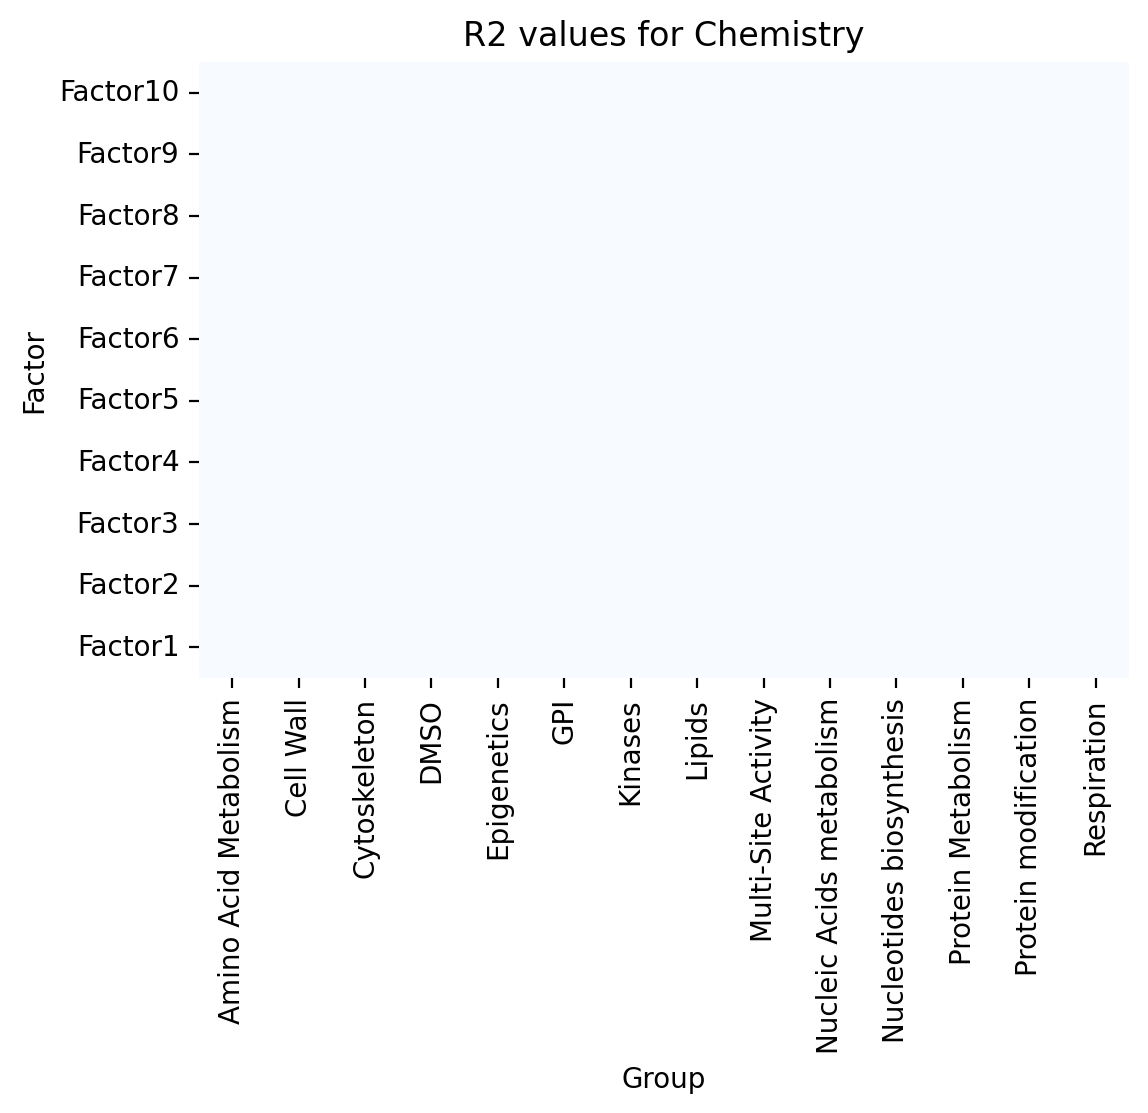

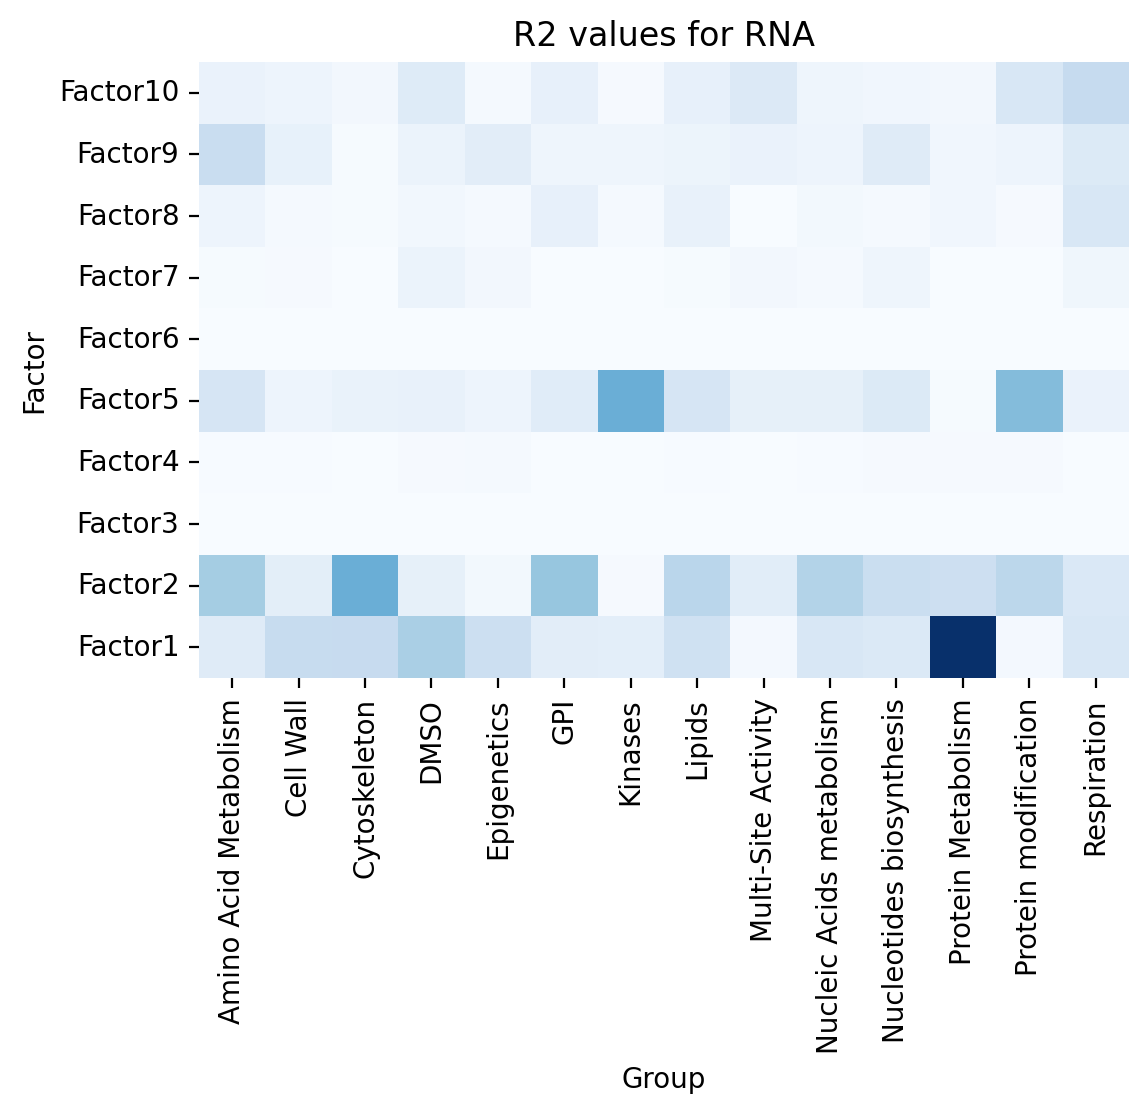

In [182]:
for view, r2 in dataframes:
    plt.figure(figsize=(6, 4))
    g  = sns.heatmap(
        r2.sort_index(level=0, ascending=False),
        cmap="Blues",
        annot=False,
        vmin = 0,
        vmax = vmax,
        cbar = False
        )
    g.set_yticklabels(g.yaxis.get_ticklabels(), rotation=0)

    plt.title(f"R2 values for {view}")
    plt.show()
    

In [94]:
mfx.plot_r2(
    m,
    factors=list(range(10)),
    #color="METADATA_mode_of_action",
    group_label="METADATA_target",
    cmap="Blues",
)
plt.savefig(f"{plot_dir}mofa_factor_r2_target.png", bbox_inches='tight')
plt.close()

In [95]:
mfx.plot_r2_pvalues(
    m,
    factors=list(range(10)),
    n_iter=10,
    group_label="METADATA_mode_of_action",
    )
plt.savefig(f"{plot_dir}mofa_factor_pvalue_moa.png", bbox_inches='tight')
plt.close()

In [96]:
plt.figure(figsize=(20, 20))
mfx.plot_r2_barplot(
    m,
    factors=list(range(10)),
    cmap="tab20",
    group_label="METADATA_mode_of_action",
    stacked=True
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig(f"{plot_dir}mofa_factor_barplot_moa.png", bbox_inches='tight')
plt.close()

<Figure size 4000x4000 with 0 Axes>

In [97]:
mfx.plot_factors_covariates_correlation(
    m, covariates=pd.get_dummies(m.metadata["METADATA_mode_of_action"])
)
plt.title("Pearson r")
plt.savefig(f"{plot_dir}mofa_factor_pearson_r_moa.png", bbox_inches='tight')
plt.close()

In [98]:
import seaborn as sns

mfx.plot_factors_covariates_correlation(
    m,
    covariates=pd.get_dummies(m.metadata["METADATA_mode_of_action"]),
    pvalues=True,
    cmap=sns.light_palette("#FF0000"),
)
plt.savefig(f"{plot_dir}mofa_factor_correlation_moa.png", bbox_inches='tight')
plt.close()

In [99]:
mfx.plot_factors_scatter(
    m,
    x=0,
    y=range(1, 10),
    legend=None,
    palette = "tab10",
    ncols=3,
    color="METADATA_mode_of_action",
    group_label="METADATA_mode_of_action"
)
plt.savefig(f"{plot_dir}mofa_multi_scatter_moa.png", bbox_inches='tight')
plt.close()

In [100]:
mfx.plot_factors_scatter(
    m,
    x=0,
    y=range(1, 10),
    legend=None,
    palette = "tab10",
    ncols=3,
    color="METADATA_target",
    group_label="METADATA_target"
)
plt.savefig(f"{plot_dir}mofa_multi_scatter_target.png", bbox_inches='tight')
plt.close()

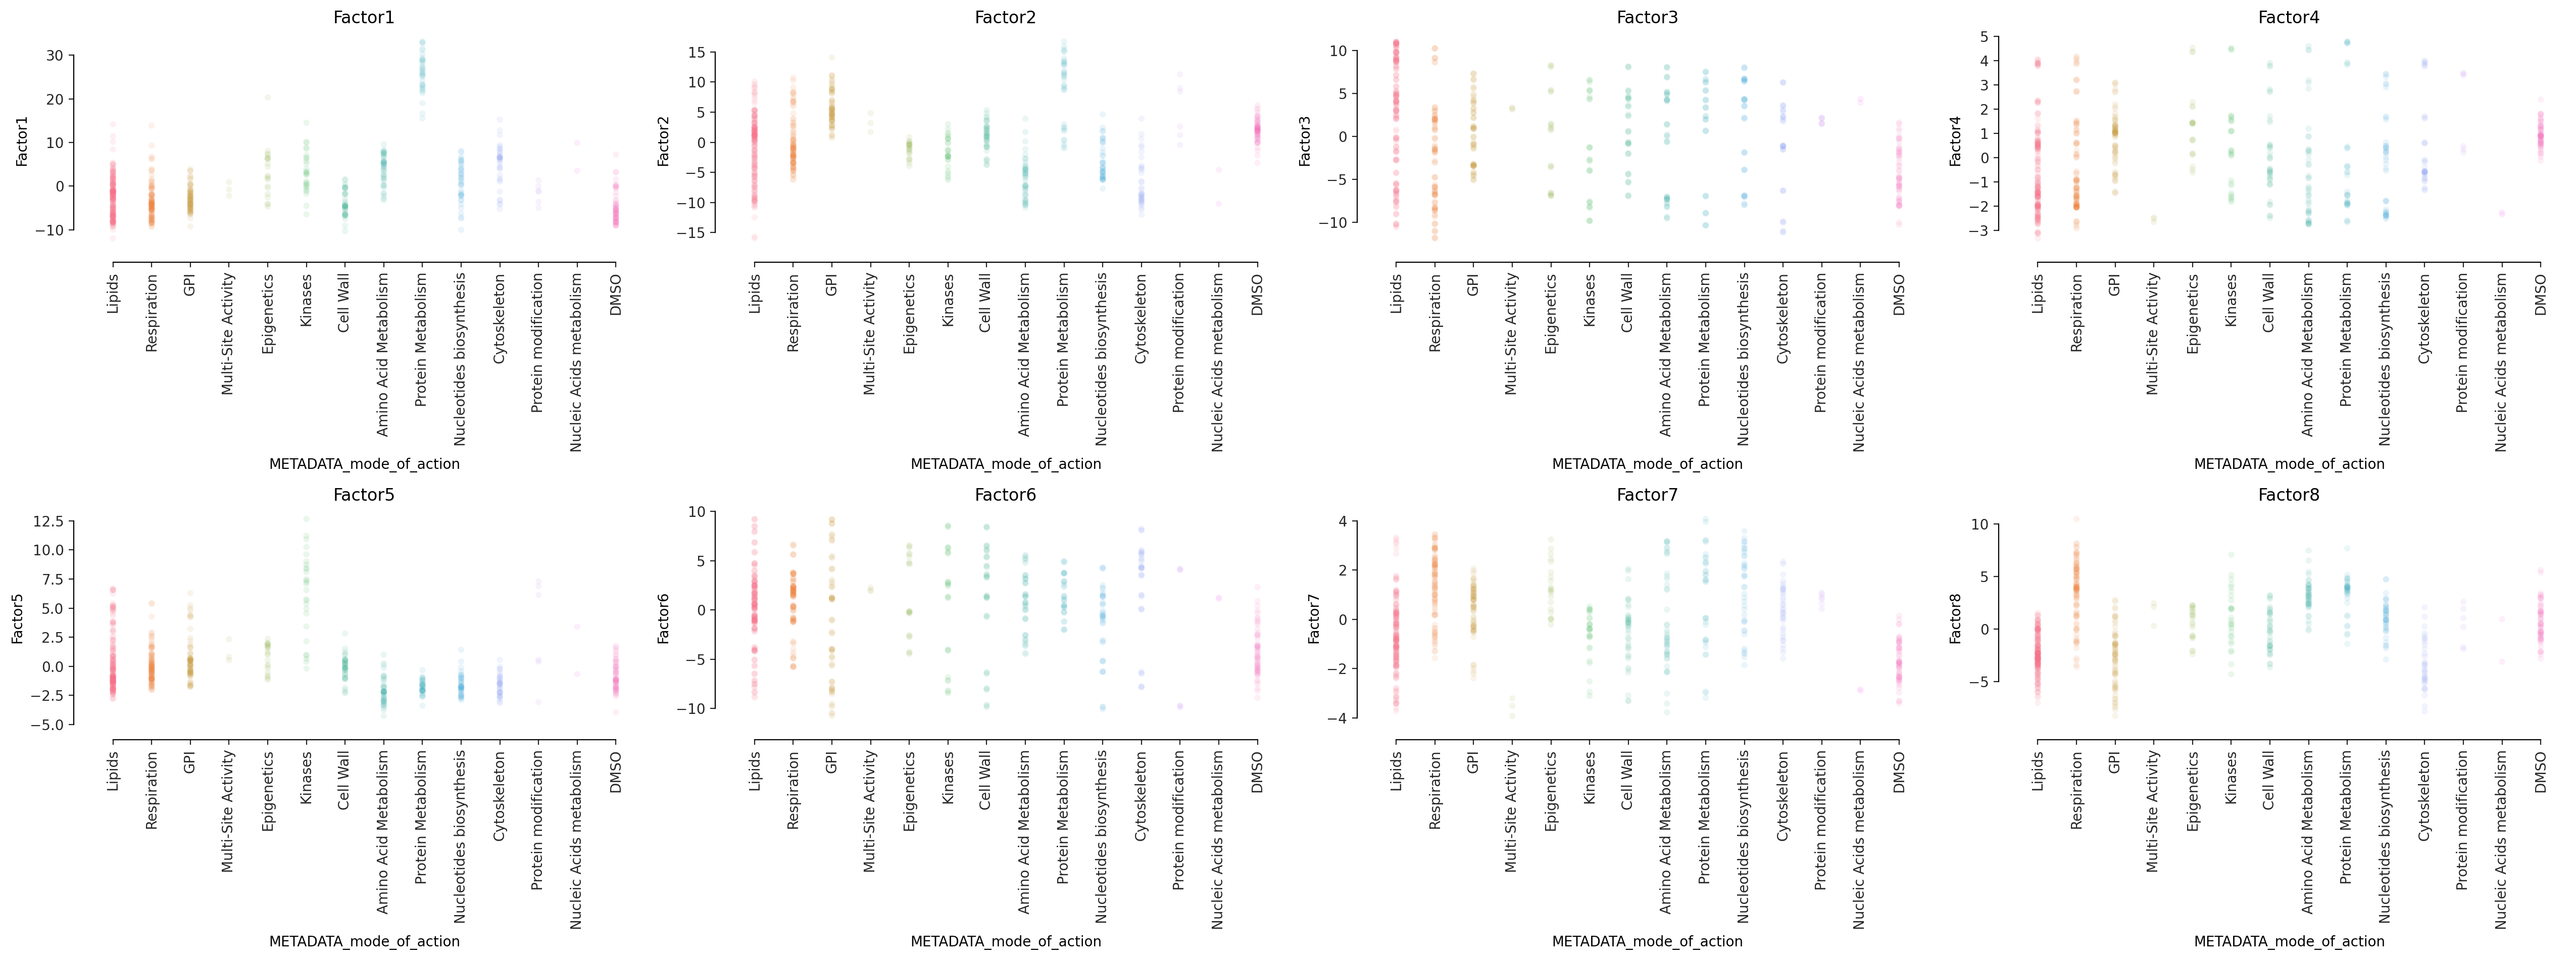

In [101]:
mfx.plot_factors_scatter(
    m,
    x="METADATA_mode_of_action",
    y=range(8),
    group_label="METADATA_mode_of_action",
    color="METADATA_mode_of_action",
    alpha=0.1,
    legend = None,
    rotate_x_labels=90,
    ncols=4,
)
plt.savefig(f"{plot_dir}mofa_factor_scatter_moa.png", bbox_inches='tight')


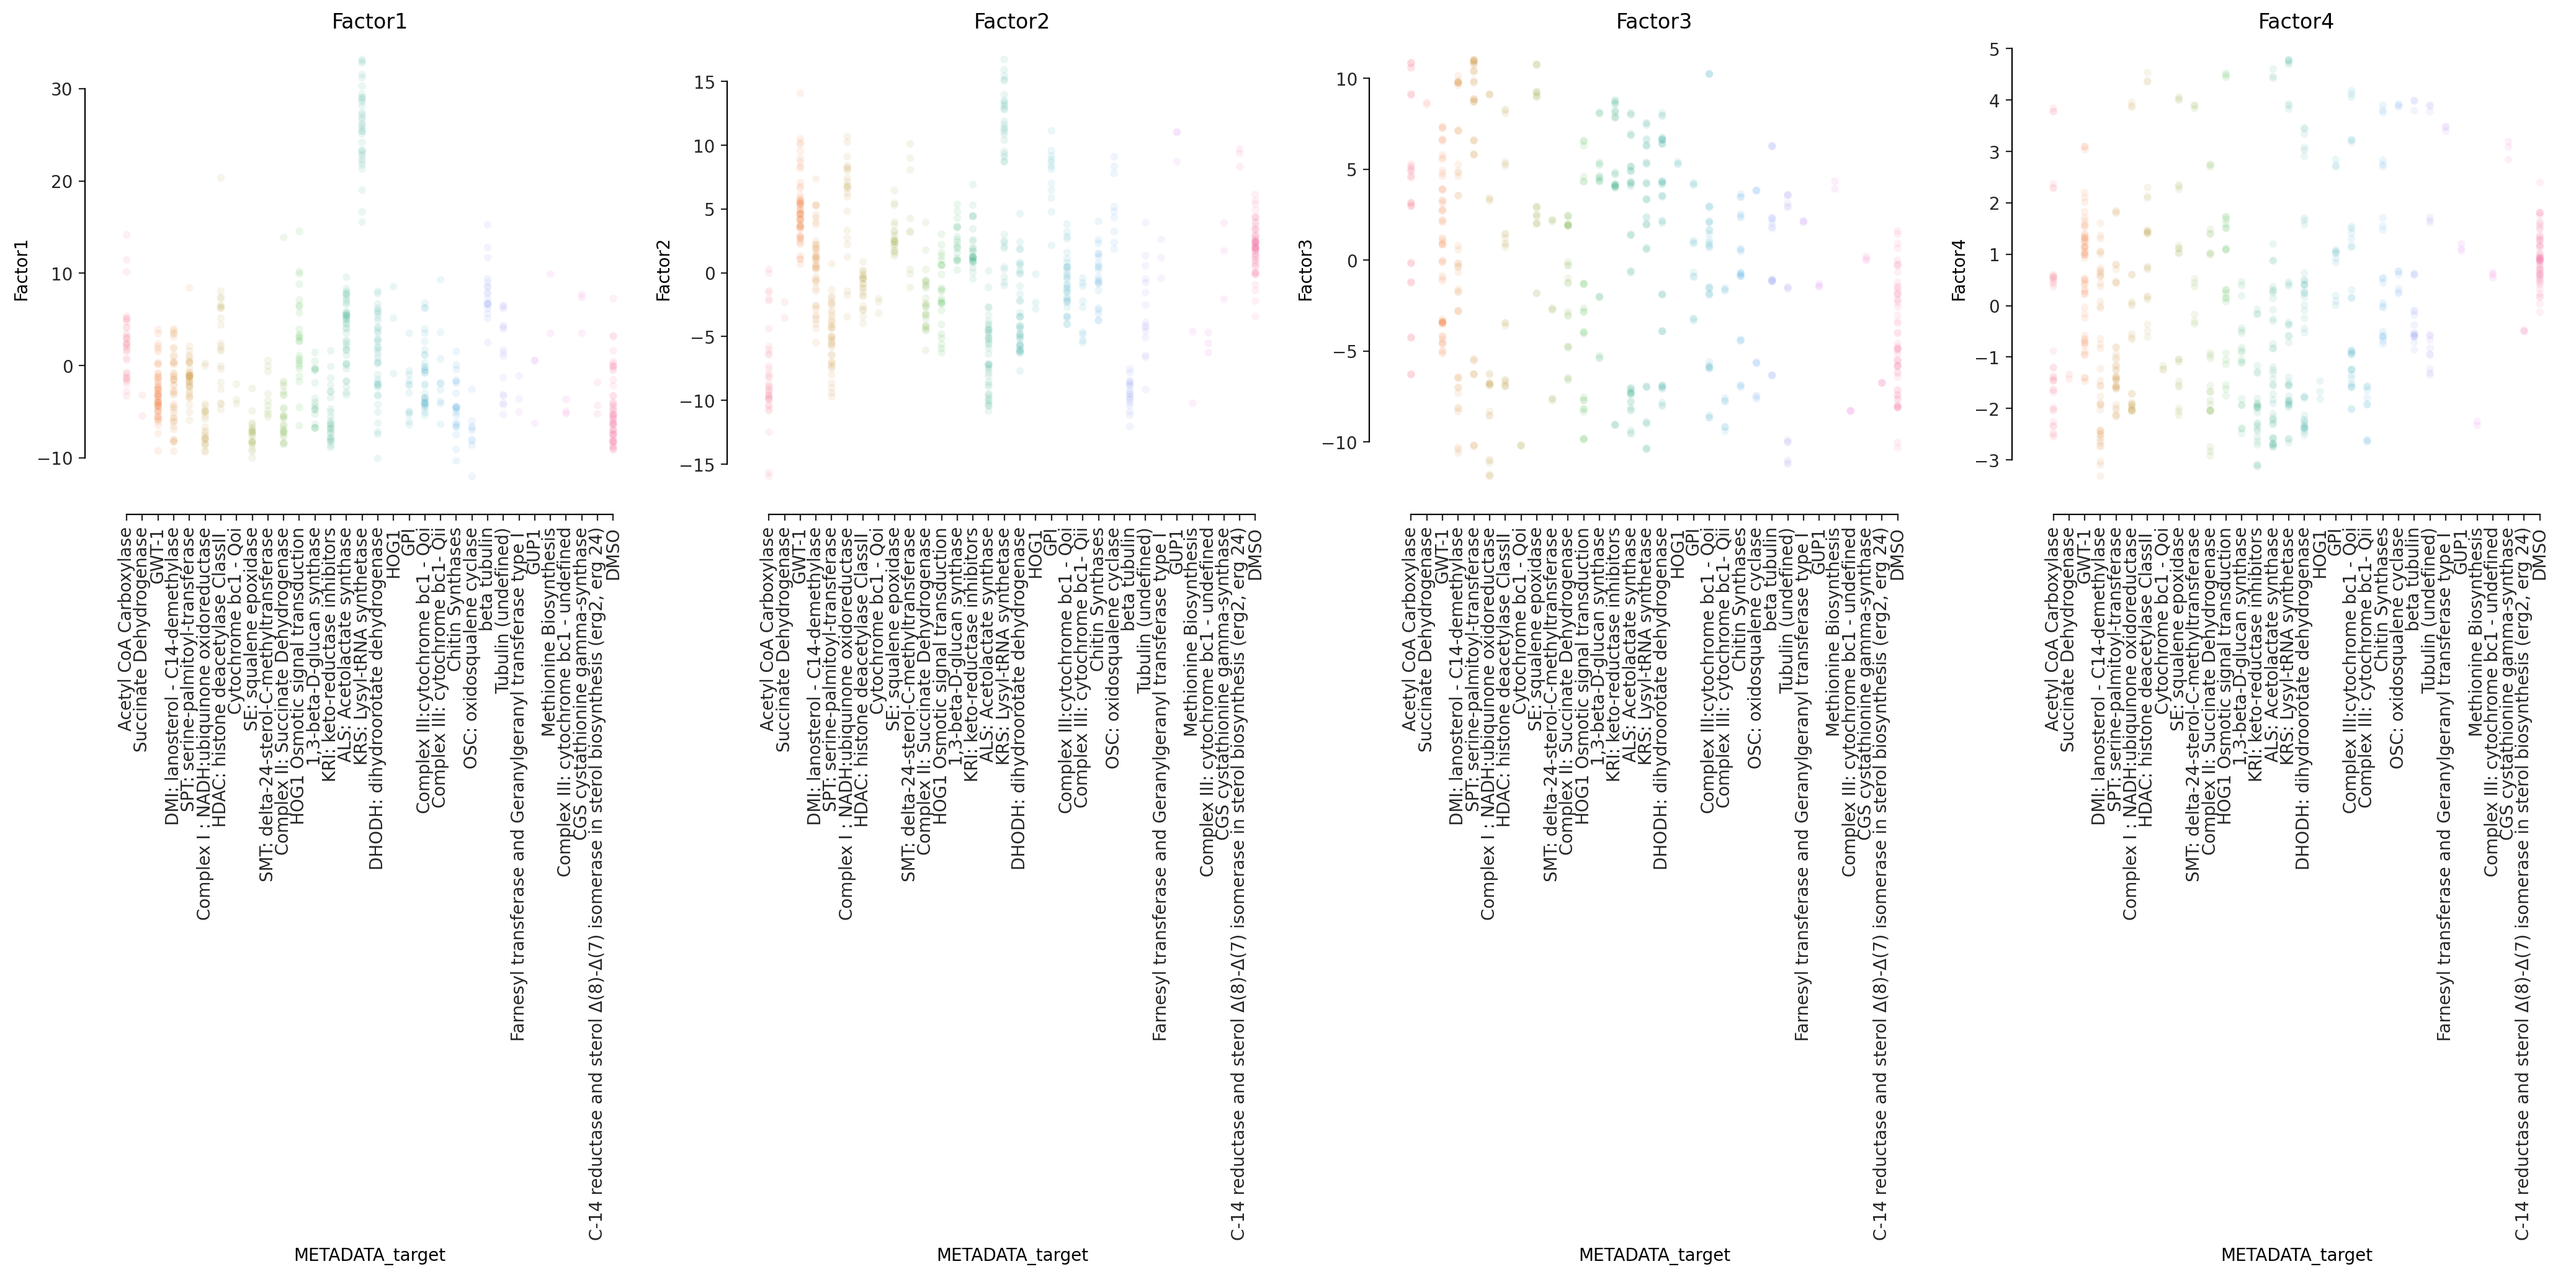

In [184]:
mfx.plot_factors_scatter(
    m,
    x="METADATA_target",
    y=range(4),
    groups = m.metadata["METADATA_target"],
    group_label="METADATA_target",
    color="METADATA_target",
    alpha=0.1,
    legend = None,
    rotate_x_labels=90,
    ncols=4,
)
plt.savefig(f"{plot_dir}mofa_factor_scatter_target.png", bbox_inches='tight')

In [103]:
transcriptomics_chemistry_and_meta_mofa = (
    f"{wd}features/lyon_transcriptomics_chemistry_mofa_and_meta.csv.gz"
)

In [104]:
df_mofa = pd.DataFrame(m.get_factors(), columns=[f"MOFA_factor{i}" for i in range(10)])
df_mofa["sample"] = m.metadata.index

In [106]:
df_merged = df.merge(df_mofa, on="sample")

In [108]:
df_merged.drop(columns=["sample"], inplace=True)

In [109]:
df_merged.head()

,GE_Bcin01g00010,GE_Bcin01g00030,GE_Bcin01g00040,GE_Bcin01g00060,GE_Bcin01g00070,GE_Bcin01g00080,GE_Bcin01g00090,GE_Bcin01g00120,GE_Bcin01g00130,GE_Bcin01g00160,...,MOFA_factor0,MOFA_factor1,MOFA_factor2,MOFA_factor3,MOFA_factor4,MOFA_factor5,MOFA_factor6,MOFA_factor7,MOFA_factor8,MOFA_factor9
0,0.080490,0.043167,0.065152,-0.027729,0.244524,0.185315,0.080212,0.077134,0.355214,0.226379,...,-0.772984,-2.195375,3.135857,0.496523,3.817306,4.661848,3.316312,-1.958515,-0.660500,-1.522883
1,0.019329,0.016021,-0.111414,0.026441,0.248501,0.059277,0.013168,0.032393,0.229482,0.336465,...,-1.124167,-1.539300,3.157002,0.556583,3.533124,4.742735,3.134183,-1.584281,-0.251421,0.650335
2,0.060572,0.157618,0.088599,0.007545,0.032652,0.208653,0.122243,-0.008660,0.476473,0.247782,...,-1.689952,-2.073619,3.163821,0.529810,3.790155,4.784801,3.079890,-1.133876,-1.612521,-0.913103
3,-0.045601,-0.015031,-0.035620,-0.040591,-0.046764,0.046006,-0.070511,-0.058903,-0.073125,1.245546,...,-3.214245,-2.302703,8.676544,-1.342159,0.163967,-1.135844,2.136118,6.491366,-0.648884,8.062224
4,-0.049901,-0.110187,-0.032953,-0.089721,-0.168995,-0.025355,-0.103505,-0.124813,-0.078171,1.327053,...,-5.464711,-3.538838,8.581395,-1.429824,-0.593684,-1.153574,2.215008,5.695770,-1.669364,5.403626


In [110]:
df_merged.to_csv(transcriptomics_chemistry_and_meta_mofa)

In [111]:
n_components = 2

In [112]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap
from sklearn.decomposition import PCA

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(m.get_factors())
pca_df = pd.DataFrame(
    data=pca_result, columns=[f"PC{i + 1}" for i in range(n_components)]
)
pca_df["MoA"] = list(m.metadata["METADATA_mode_of_action"])
pca_df["Target"] = list(m.metadata["METADATA_target"])

plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="MoA", palette="tab10", ax=ax)
plt.title("PCA of MoFA factors - MoA")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f"{plot_dir}mofa_PCA_moa.png", bbox_inches='tight')
plt.close()
# plt.show()

plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="MoA", palette="tab10", ax=ax)
plt.title("PCA of MoFA factors - Target")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f"{plot_dir}mofa_PCA_moa.png", bbox_inches='tight')
plt.close()
# plt.show()


In [113]:
min_dist = 0.9
n_neighbors = 50

# Step 3: Run UMAP on the distance matrix
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    # metric='precomputed',  # Use the precomputed distance matrix
    min_dist=min_dist,
)
umap_result = pd.DataFrame(
    reducer.fit_transform(m.get_factors()), columns=["UMAP1", "UMAP2"]
)

In [114]:
umap_result["MoA"] = list(m.metadata["METADATA_mode_of_action"])
umap_result["Target"] = list(m.metadata["METADATA_target"])

plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.scatterplot(
    data=umap_result, x="UMAP1", y="UMAP2", hue="MoA", palette="tab10", ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("UMAP of MoFa factors - MoA")
plt.savefig(f"{plot_dir}mofa_UMAP_moa.png", bbox_inches='tight')
plt.close()

plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.scatterplot(
    data=umap_result, x="UMAP1", y="UMAP2", hue="Target", palette="tab10", ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("UMAP of MoFa factors - Target")
plt.savefig(f"{plot_dir}mofa_UMAP_target.png", bbox_inches='tight')
plt.close()